In [1]:
import subprocess
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
base : str = """
let counter () =
    reg (fun v -> v + 1) last 0 ;;

let rec wait(n) =
    if n <= 1 then () else wait(n-1) ;;

let rec wait_true(n) =
    if n <= 1 then true else wait_true(n-1) ;;
    
let rec wait_false(n) =
    if n <= 1 then false else wait_false(n-1) ;;

"""

def main(function_calls: list[str]):
    s = """
let main () =
    let c = counter () in
    exec
"""
    for i, v in enumerate(function_calls):
        s += f"print_int c; print_string \"_\";"
        s += f"{v};"
        s += f"print_int c; print_newline ();"
    s += "print_string \"---\"; print_newline (); () default () ;;"
    return s

def generate_file(filename: str, functions: dict[str, str], tabs: list[str]):
    with open("bench/" + filename, "w") as f:
        f.write(base)
        for t in tabs:
            f.write(t + "\n")
        for v in functions.values():
            f.write(v)
        f.write(main(functions.keys()))

def run(filename: str):
    cmd = " ".join(["cd", "../eclat/eclat-compiler", ";", "./eclat", f"../../adrien/bench/{filename}", ";", "make", "simul", "NS=40000000"])
    res = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    return res.stdout

In [3]:
global_stats = {}

def format_output(data):
  start = False
  l = []
  for line in data.split("\n"):
      if "--vcd" in line:
          start = True
          continue
      if start:
          if "---" in line:
              break
          s = line.split("_")
          if len(s) == 2 and s[0].isdigit() and s[1][1:].strip().isdigit():
              l += [ int(s[1][1:].strip()) - int(s[0])]
  return l

tab = 256

times = [1, 100, 500, 1000]

for t in times:
  base += f"let wait_true_{t} _ = wait_true({t}) ;;\n"
  base += f"let wait_false_{t} _ = wait_false({t}) ;;\n"

def get_values_for_deg(k, n):
    return [a[i][0] / a[i][n] for i in range(4) for a in [list(v.values()) for v in global_stats[k].values()]]

# v = {1: [513, 385, 321, 289], 10: [1665, 961, 609, 433], 50: [6785, 3521, 1889, 1073], 100: [13185, 6721, 3489, 1873]}
# a = [513, 385, 321, 289], [1665, 961, 609, 433], ...
# deg = 1
# [385, 961, ..., 321, 609, ..., 289, 433, ...]

def draw_graphs(k):
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(1, 9):
        ax.plot([times[0], times[-1]], [i, i], "--", c="grey")
    for deg in range(4):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [e[0] / e[deg]]
        ax.plot(times, l, label=(f"${k}$" + "$_{" + f"{2**(deg)}" + "}$"))
        ax.set_xlabel("f execution time")
        ax.set_ylabel("acceleration")
        ax.set_xticks(times)
        ax.set_title(f)
    ax.legend(loc="upper left")
    plt.show()


## exists.ecl

In [40]:
stats = { 2**(7+i) : { v: [] for v in times } for i in range(4) }

cpt = 1

for time in times:
  functions = {
        f"let _ = exists_1(wait_false_{time}, t) in ()": """let exists_1(f, t) =
      let rec loop (i) =
        if i >= t.length then false else
        let update(i) = f (t[i])
        in
        let v1 = update (i) in
        if v1 then true
        else loop (i+1)
      in
      loop 0 ;;
      """,
      
        f"let _ = exists_2(wait_false_{time}, t) in ()": """let exists_2(f, t) =
      let rec loop (i) =
        if i >= t.length - 1 then false else
        let update(i) = f (t[i])
        in
        let v1 = update (i)
        and v2 = update (i+1) in
        if v1 or v2 then true
        else loop (i+2)
      in
      loop 0 ;;
      """,
      
        f"let _ = exists_4(wait_false_{time}, t) in ()": """let exists_4(f, t) =
      let rec loop (i) =
        if i >= t.length - 3 then false else
        let update(i) = f (t[i])
        in
        let v1 = update (i)
        and v2 = update (i+1)
        and v3 = update (i+2)
        and v4 = update (i+3) in
        if v1 or v2 or v3 or v4 then true
        else loop (i+4)
      in
      loop 0 ;;
      """,
      
        f"let _ = exists_8(wait_false_{time}, t) in ()": """let exists_8(f, t) =
      let rec loop (i) =
        if i >= t.length - 7 then false else
        let update(i) = f (t[i])
        in
        let v1 = update (i)
        and v2 = update (i+1)
        and v3 = update (i+2)
        and v4 = update (i+3)
        and v5 = update (i+4)
        and v6 = update (i+5)
        and v7 = update (i+6)
        and v8 = update (i+7) in
        if v1 or v2 or v3 or v4 or v5 or v6 or v7 or v8 then true
        else loop (i+8)
      in
      loop 0 ;;
      """,
    }
  filename = "exists_bench.ecl"
  
  generate_file(filename, functions, [f"let static t = 0^{tab} ;;"])
  print(f"generated file {cpt}/4")
  stdout = run(filename)
  print(f"executed file {cpt}/4")
  stats[time] = format_output(stdout)
  cpt += 1

generated file 1/4


executed file 1/4
generated file 2/4
executed file 2/4
generated file 3/4
executed file 3/4
generated file 4/4
executed file 4/4


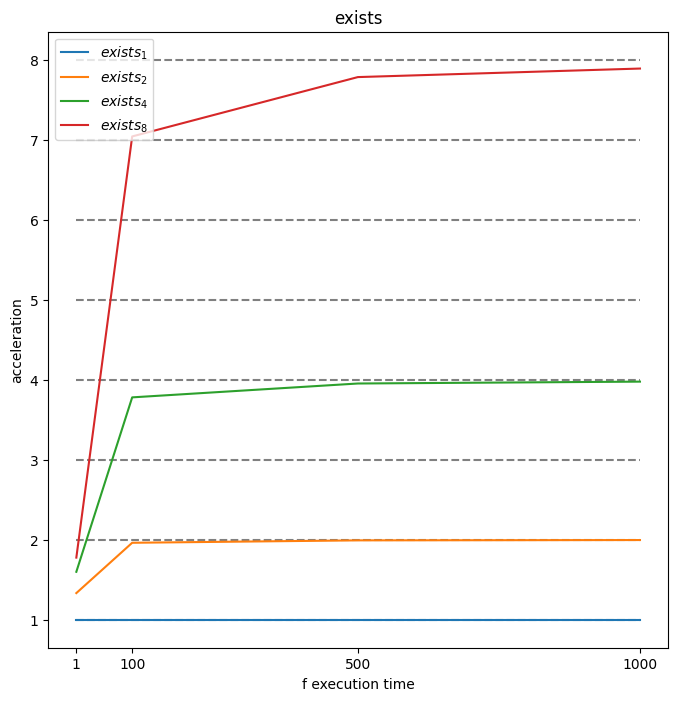

In [41]:
global_stats["exists"] = stats
draw_graphs("exists")

## for_all.ecl

In [104]:
stats = { 2**(7+i) : { v: [] for v in times } for i in range(4) }

cpt = 1

for time in times:
  functions = {
        f"let _ = for_all_1(wait_true_{time}, t) in ()": """let for_all_1(f, t) =
      let rec loop (i) =
    if i >= t.length then true else
    let update(i) = f (t[i])
    in
    let v1 = update (i) in
    if v1 then loop (i+1)
    else false
  in
  loop 0 ;;
      """,
      
        f"let _ = for_all_2(wait_true_{time}, t) in ()": """let for_all_2(f, t) =
      let rec loop (i) =
    if i >= t.length - 1 then true else
    let update(i) = f (t[i])
    in
    let v1 = update (i)
    and v2 = update (i+1) in
    if v1 && v2 then loop (i+2)
    else false
  in
  loop 0 ;;
      """,
      
        f"let _ = for_all_4(wait_true_{time}, t) in ()": """let for_all_4(f, t) =
      let rec loop (i) =
    if i >= t.length - 3 then true else
    let update(i) = f (t[i])
    in
    let v1 = update (i)
    and v2 = update (i+1)
    and v3 = update (i+2)
    and v4 = update (i+3) in
    if v1 && v2 && v3 && v4 then loop (i+4)
    else false
  in
  loop 0 ;;
      """,
      
        f"let _ = for_all_8(wait_true_{time}, t) in ()": """let for_all_8(f, t) =
      let rec loop (i) =
    if i >= t.length - 7 then true else
    let update(i) = f (t[i])
    in
    let v1 = update (i)
    and v2 = update (i+1)
    and v3 = update (i+2)
    and v4 = update (i+3)
    and v5 = update (i+4)
    and v6 = update (i+5)
    and v7 = update (i+6)
    and v8 = update (i+7) in
    if v1 && v2 && v3 && v4 && v5 && v6 && v7 && v8 then loop (i+8)
    else false
  in
  loop 0 ;;
      """,
    }
  filename = "for_all_bench.ecl"
    
  generate_file(filename, functions, [f"let static t = 0^{tab} ;;"])
  print(f"generated file {cpt}/4")
  stdout = run(filename)
  print(f"executed file {cpt}/4")
  stats[time] = format_output(stdout)
  cpt += 1
global_stats["for_all"] = stats

generated file 1/4
executed file 1/4
generated file 2/4
executed file 2/4
generated file 3/4
executed file 3/4
generated file 4/4
executed file 4/4


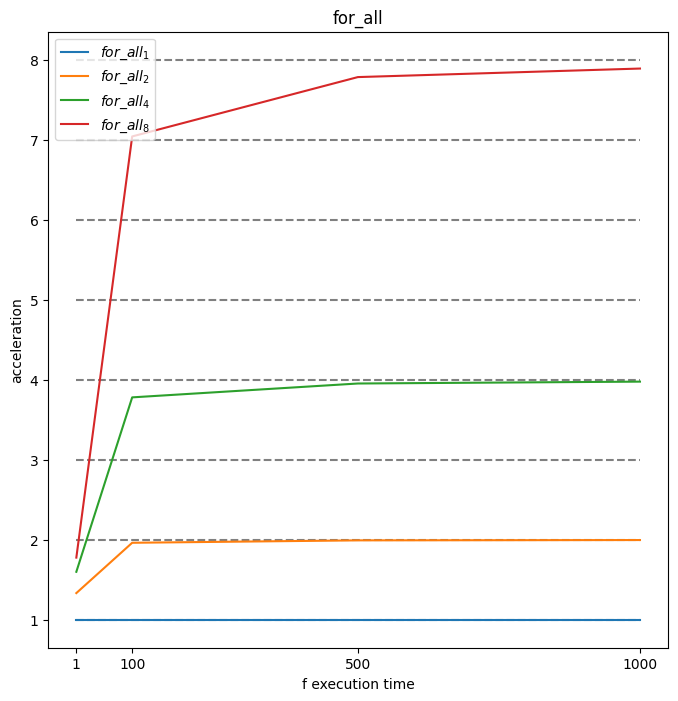

In [106]:
def draw_graphs(k):
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(1, 9):
        ax.plot([times[0], times[-1]], [i, i], "--", c="grey")
    for deg in range(4):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [e[0] / e[deg]]
        ax.plot(times, l, label=(f"$for\_all$" + "$_{" + f"{2**(deg)}" + "}$"))
        ax.set_xlabel("f execution time")
        ax.set_ylabel("acceleration")
        ax.set_xticks(times)
        ax.set_title("for_all")
    ax.legend(loc="upper left")
    plt.show()
draw_graphs("for_all")

## fold.ecl

In [44]:
stats = { 2**(7+i) : { v: [] for v in times } for i in range(4) }

cpt = 1

wait_fold = ""
for time in times:
  wait_fold += f"let rec wait_fold_{time}(init, v) = wait({time - 1}); init ;;\n"

for time in times:
  functions = {
        f"let _ = fold_1(wait_fold_{time}, 0, t) in ()": f"""{wait_fold}let fold_1(f, init, t) =
  let rec loop (init, i) =
    if i >= t.length then init else
    loop (f(init, t[i]), i+1)
  in loop (init, 0) ;;
      """,
      
        f"let _ = fold_2(wait_fold_{time}, 0, t) in ()": """let fold_2(f, init, t) =
      let rec loop (init, i) =
    if i >= t.length - 1 then init else
    let v1 = t[i] in
    let v2 = t[i+1] and
        r1 = f(init, v1) in
    loop (f(r1, v2), i+2)
  in loop (init, 0) ;;
      """,
      
        f"let _ = fold_4(wait_fold_{time}, 0, t) in ()": """let fold_4(f, init, t) =
  let rec loop (init, i) =
    if i >= t.length - 3 then init else
    let v1 = t[i] in
    let v2 = t[i+1] and
        r1 = f(init, v1) in
    let v3 = t[i+2] and
        r2 = f(r1, v2) in
    let v4 = t[i+3] and
        r3 = f(r2, v3) in
    loop (f(r3, v4), i+4)
  in loop (init, 0) ;;
      """,
      
        f"let _ = fold_8(wait_fold_{time},0, t) in ()": """let fold_8(f, init, t) =
  let rec loop (init, i) =
    if i >= t.length - 7 then init else
    let v1 = t[i] in
    let v2 = t[i+1] and
        r1 = f(init, v1) in
    let v3 = t[i+2] and
        r2 = f(r1, v2) in
    let v4 = t[i+3] and
        r3 = f(r2, v3) in
    let v5 = t[i+4] and
        r4 = f(r3, v4) in
    let v6 = t[i+5] and
        r5 = f(r4, v5) in
    let v7 = t[i+6] and
        r6 = f(r5, v6) in
    let v8 = t[i+7] and
        r7 = f(r6, v7) in
    loop (f(r7, v8), i+8)
  in loop (init, 0) ;;
      """,
    }
  filename = "fold_bench.ecl"
    
  generate_file(filename, functions, [f"let static t = 0^{tab} ;;"])
  print(f"generated file {cpt}/4")
  stdout = run(filename)
  print(f"executed file {cpt}/4")
  stats[time] = format_output(stdout)
  cpt += 1
global_stats["fold"] = stats

generated file 1/4
executed file 1/4
generated file 2/4
executed file 2/4
generated file 3/4
executed file 3/4
generated file 4/4
executed file 4/4


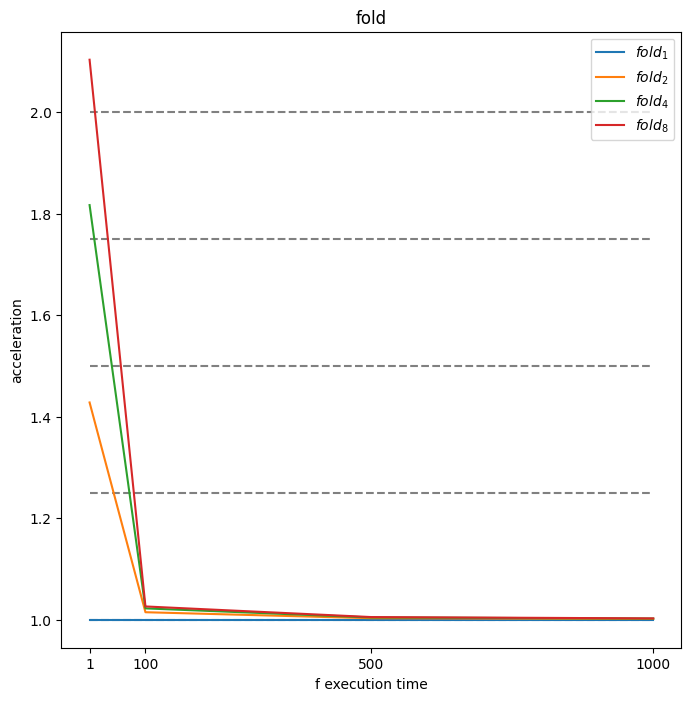

In [51]:
def draw_graphs(k):
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(5):
        ax.plot([times[0], times[-1]], [1+i/4, 1+i/4], "--", c="grey")
    for deg in range(4):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [e[0] / e[deg]]
        ax.plot(times, l, label=(f"${k}$" + "$_{" + f"{2**(deg)}" + "}$"))
        ax.set_xlabel("f execution time")
        ax.set_ylabel("acceleration")
        ax.set_xticks(times)
        ax.set_title(k)
    ax.legend(loc="upper right")
    plt.show()

draw_graphs("fold")

## pipe.ecl

In [4]:
stats = { 2**(7+i) : { v: [] for v in times } for i in range(4) }

cpt = 1

iteri = """
let iteri(f, d, src, dst)=
  let rec loop (i) =
    if i >= dst.length then ()
    else
      let (v, b) = src.(i) in
      if b then (
        dst.(i) <- (d, false);
        dst.(i) <- (f v, true);
        loop (i+1)
      ) else loop i
  in loop 0 ;;
"""

init_tabs = """
let init_tabs () =
  let rec loop (i) =
  if i >= src.length then ()
  else (
    src.(i) <- (0, true);
    dst.(i) <- (0, false);
    loop (i+1)) in
  loop (0) ;;
"""

wait_pipe = ""
for time in times:
  wait_pipe += f"let rec wait_pipe_{time}(v) = wait({time - 1}); v ;;\n"

for time in times:
  wait_pipe = f"let rec wait_pipe_{time}(v) = wait({time - 1}); v ;;\n"
  functions = {
        f"let _ = not_piped2(wait_pipe_{time}, wait_pipe_{time}, src, dst) in let _ = init_tabs () in ()": f"""{wait_pipe}{iteri}{init_tabs}let not_piped2(f, g, src, dst) =
  let rec loop (j) =
    if j >= src.length then ()
    else (
      dst.(j) <- (g (f (src.(j)))); loop (j+1)
    )
  in loop (0) ;;
      """,
      
        f"let _ = pipe2(wait_pipe_{time}, wait_pipe_{time}, 0, 0, src, dst) in let _ = init_tabs () in ()": f"""let pipe2(f, g, df, dg, src, dst) =
        let inter1 = (0, false)^{tab} in
  let _ = iteri(f, df, src, inter1)
  and _ = iteri(g, dg, inter1, dst)
  in () ;;
      """,
      
        f"let _ = not_piped3(wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, src, dst) in let _ = init_tabs () in ()": f"""let not_piped3(f, g, h, src, dst) =
  let rec loop (j) =
    if j >= src.length then ()
    else (
      dst.(j) <- (h (g (f (src.(j))))); loop (j+1)
    )
  in loop (0) ;;
      """,
      
        f"let _ = pipe3(wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, 0, 0, 0, src, dst) in let _ = init_tabs () in ()": f"""let pipe3(f, g, h, df, dg, dh, src, dst) =
  let inter2 = (0, false)^{tab} in
  let _ = pipe2(f, g, df, dg, src, inter2)
  and _ = iteri(h, dh, inter2, dst)
  in ();;
      """,
      
        f"let _ = not_piped4(wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, src, dst) in let _ = init_tabs () in ()": f"""let not_piped4(f, g, h, i, src, dst) =
  let rec loop (j) =
    if j >= src.length then ()
    else (
      dst.(j) <- (i (h (g (f (src.(j)))))); loop (j+1)
    )
  in loop (0) ;;
      """,
      
        f"let _ = pipe4(wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, wait_pipe_{time}, 0, 0, 0, 0, src, dst) in let _ = init_tabs () in ()": f"""let pipe4(f, g, h, i, df, dg, dh, di, src, dst) =
  let inter2 = (0, false)^256 in
  let _ = pipe2(f, g, df, dg, src, inter2)
  and _ = pipe2(h, i, dh, di, inter2, dst)
  in () ;;
      """,
    }
  filename = "pipe_bench.ecl"
    
  generate_file(filename, functions, [f"let static src = (0, true)^{tab} ;;",
                                      f"let static dst = (0, false)^{tab} ;;"])
  print(f"generated file {cpt}/4")
  stdout = run(filename)
  print(f"executed file {cpt}/4")
  stats[time] = format_output(stdout)
  cpt += 1
global_stats["pipe"] = stats

generated file 1/4
executed file 1/4
generated file 2/4
executed file 2/4
generated file 3/4
executed file 3/4
generated file 4/4
executed file 4/4


{128: {1: [], 100: [], 500: [], 1000: []}, 256: {1: [], 100: [], 500: [], 1000: []}, 512: {1: [], 100: [], 500: [], 1000: []}, 1024: {1: [], 100: [], 500: [], 1000: []}, 1: [3586, 3596, 4098, 3605, 4610, 3614], 100: [53762, 28783, 79362, 28891, 104962, 28999], 500: [258562, 131582, 386562, 132089, 514562, 132596], 1000: [514562, 260083, 770562, 261091, 1026562, 262099]}


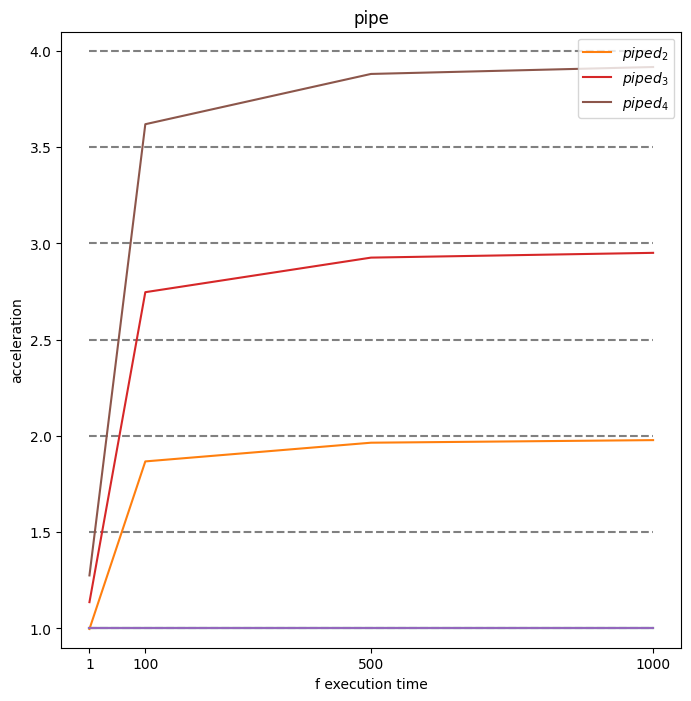

In [5]:
print(global_stats["pipe"])
def get_values_for_deg_pipe(k, n):
    return [a[i][n] / a[i][n-1] for i in range(3) for a in [list(v.values()) for v in global_stats[k].values()]]

def draw_graphs(k):
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    ax = fig.add_subplot(1, 1, 1)
    for i in range(9):
        ax.plot([times[0], times[-1]], [1+i/2, 1+i/2], "--", c="grey")
    for deg in range(6):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [1 if deg % 2 == 0 else e[deg-1] / e[deg]]
        lab = "" if deg % 2 == 0 else (f"$piped$" + "$_{" + f"{int(1+(deg+1)/2)}" + "}$")
        ax.plot(times, l, label=lab)
        ax.set_xlabel("f execution time")
        ax.set_ylabel("acceleration")
        ax.set_xticks(times)
        ax.set_ybound(0.9, 4.1)
        ax.set_title("pipe")
    ax.legend(loc="upper right")
    plt.show()

draw_graphs("pipe")

## iteri_farm.ecl

In [97]:
stats = { 2**(7+i) : { v: [] for v in times } for i in range(4) }

cpt = 1

for time in times:
  functions = {
        f"iteri((fun (i, v) -> if i mod 2 = 0 then wait({100 + time}) else wait(100)), t)": """let iteri(f, t) =
    let rec loop (i) =
        if i >= t.length then () else (
            let () = f(i, t.(i))
            in loop (i+1)
        )
    in loop (0) ;;
      """,
        f"iteri_8((fun (i, v) -> if i mod 2 = 0 then wait({100 + time}) else wait(100)), t)": """let iteri_8(f, t) =
    let rec loop (i) =
        if i >= t.length then () else (
            let () = f(i, t.(i))
            and () = f(i+1, t.(i+1))
            and () = f(i+2, t.(i+2))
            and () = f(i+3, t.(i+3))
            and () = f(i+4, t.(i+4))
            and () = f(i+5, t.(i+5))
            and () = f(i+6, t.(i+6))
            and () = f(i+7, t.(i+7))
            in loop (i+8)
        )
    in loop (0) ;;
      """,
        f"iteri_farm((fun (i, v) -> if i mod 2 = 0 then wait({100 + time}) else wait(100)), t)": """let iteri_farm(f, t) =
    let n = t.length in
    let idx = 0^1 in
    let rec loop() =
        (* let i = idx(false, false) in *)
        let i = idx.(0) in
        (* if i >= n then () else (let _ = idx(true, false) in let () = f(i, t.(i)) in loop ()) *)
        if i >= n then () else (idx.(0) <- i + 1; let () = f(i, t.(i)) in loop ())
    in
    let () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    (* in let _ = idx(false, true) in () ;; *)
    in idx.(0) <- 0; () ;;
      """,
        f"iteri((fun _ -> wait({time})), t)": """let iteri(f, t) =
    let rec loop (i) =
        if i >= t.length then () else (
            let () = f(i, t.(i))
            in loop (i+1)
        )
    in loop (0) ;;
      """,
        f"iteri_8((fun _ -> wait({time})), t)": """let iteri_8(f, t) =
    let rec loop (i) =
        if i >= t.length then () else (
            let () = f(i, t.(i))
            and () = f(i+1, t.(i+1))
            and () = f(i+2, t.(i+2))
            and () = f(i+3, t.(i+3))
            and () = f(i+4, t.(i+4))
            and () = f(i+5, t.(i+5))
            and () = f(i+6, t.(i+6))
            and () = f(i+7, t.(i+7))
            in loop (i+8)
        )
    in loop (0) ;;
      """,
        f"iteri_farm((fun _ -> wait({time})), t)": """let iteri_farm(f, t) =
    let n = t.length in
    let idx = 0^1 in
    let rec loop() =
        let i = idx.(0) in
        if i >= n then () else (idx.(0) <- i + 1; let () = f(i, t.(i)) in loop ())
    in
    let () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    and () = loop ()
    (* in let _ = idx(false, true) in () ;; *)
    in idx.(0) <- 0; () ;;
      """,
    }
  filename = "farm_bench.ecl"
    
  generate_file(filename, functions, [f"let static t = 0^{tab} ;;"])
  print(f"generated file {cpt}/4")
  stdout = run(filename)
  print(f"executed file {cpt}/4")
  stats[time] = format_output(stdout)
  cpt += 1
global_stats["farm"] = stats

generated file 1/4
executed file 1/4
generated file 2/4
executed file 2/4
generated file 3/4
executed file 3/4
generated file 4/4
executed file 4/4


{128: {1: [], 100: [], 500: [], 1000: []}, 256: {1: [], 100: [], 500: [], 1000: []}, 512: {1: [], 100: [], 500: [], 1000: []}, 1024: {1: [], 100: [], 500: [], 1000: []}, 1: [26497, 3745, 3488, 1025, 577, 1075], 100: [39169, 6881, 5148, 26369, 3745, 3457], 500: [90369, 19681, 11739, 128769, 16545, 16257], 1000: [154369, 35681, 19865, 256769, 32545, 32257]}


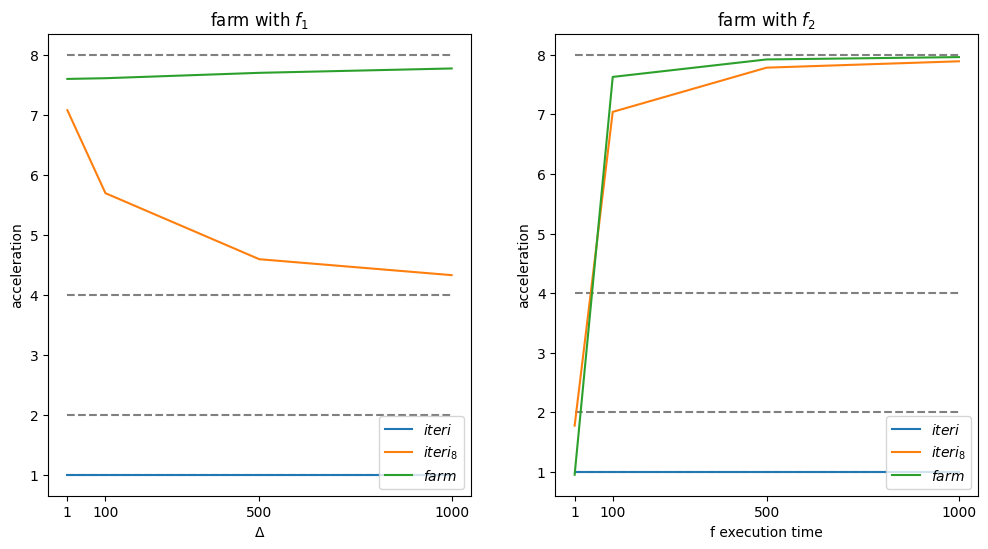

In [99]:
labels = ["$iteri$", "$iteri_8$", "$farm$"]
print(stats)

def draw_graphs(k):
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(6)
    ax1, ax2 = fig.subplots(1, 2)
    for i in range(4):
        ax1.plot([times[0], times[-1]], [2**i, 2**i], "--", c="grey")
        ax2.plot([times[0], times[-1]], [2**i, 2**i], "--", c="grey")
    for deg in range(3):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [1 if deg == 0 else (e[0] / e[deg])]
        ax1.plot(times, l, label=labels[deg])
        ax1.set_xlabel("$\Delta$")
        ax1.set_ylabel("acceleration")
        ax1.set_xticks(times)
        ax1.set_title("farm with $f_1$")

    for deg in range(3):
        l = []
        for e in [global_stats[k][ti] for ti in times]:
            l += [1 if deg == 0 else (e[3] / e[deg+3])]
        ax2.plot(times, l, label=labels[deg])
        ax2.set_xlabel("f execution time")
        ax2.set_ylabel("acceleration")
        ax2.set_xticks(times)
        ax2.set_title("farm with $f_2$")
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
    plt.show()
    
draw_graphs("farm")